In [81]:
import torch
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from itertools import product
import matplotlib as mpl

def to_corr(x, ref):
    return (ref[0] - x) / (ref[0] - ref[1])
def to_corr_error(x, ref):
    return x / (ref[0] - ref[1])

colors = plt.get_cmap('tab20')

In [82]:
mpl.rcParams['figure.dpi'] = 150
mpl.rc('font', family='serif', serif='STIXGeneral', size=9)
mpl.rc('mathtext', fontset='stix')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [83]:
def get_ref(references,ref,system):
    data = []
    for ansatz in ['SD-SJ','SD-SJBF','MD-SJ','MD-SJBF']:
        try:
            ref_i = references.loc(0)[ref].loc(0)[system].loc(0)
            if ansatz in ['SD-SJ','SD-SJBF'] and not np.isnan(ref_i[f"{ansatz} energy"]):
                data.append((100-100*to_corr(ref_i[f"{ansatz} energy"],refs_exact.loc(0)[system]),100*to_corr_error(ref_i[f"{ansatz} error"],refs_exact.loc(0)[system]),1))
            else:
                data.append((100-100*to_corr(ref_i[f"{ansatz} energy"],refs_exact.loc(0)[system]),100*to_corr_error(ref_i[f"{ansatz} error"],refs_exact.loc(0)[system]),ref_i[f"{ansatz} nCSF"]))
        except:
            data.append((float('NaN'),float('NaN'),float('NaN')))
    return np.array(data)

In [79]:
refs_qmc = pd.read_csv('../data/extern/small-systems-vmc.csv').set_index(['reference','system'])
refs_exact =  pd.read_csv('/home/mi/zenoone/Dokumente/dlqmc-pub/dlqmc-project/data/extern/small-systems-exact.csv').set_index(['system'])
systems = ['H2', 'LiH', 'Li2', 'Be', 'B', 'C']
with h5py.File(f'../data/raw/data_pub_small_systems.h5', 'a') as f:
    data_paulinet=np.array([[(100-100*to_corr(f[system][ansatz].attrs['energy'][0],refs_exact.loc(0)[system]),100*to_corr_error(f[system][ansatz].attrs['energy'][1],refs_exact.loc(0)[system]))for ansatz in ['SD-SJ','SD-SJBF','MD-SJ','MD-SJBF']] for system in systems])

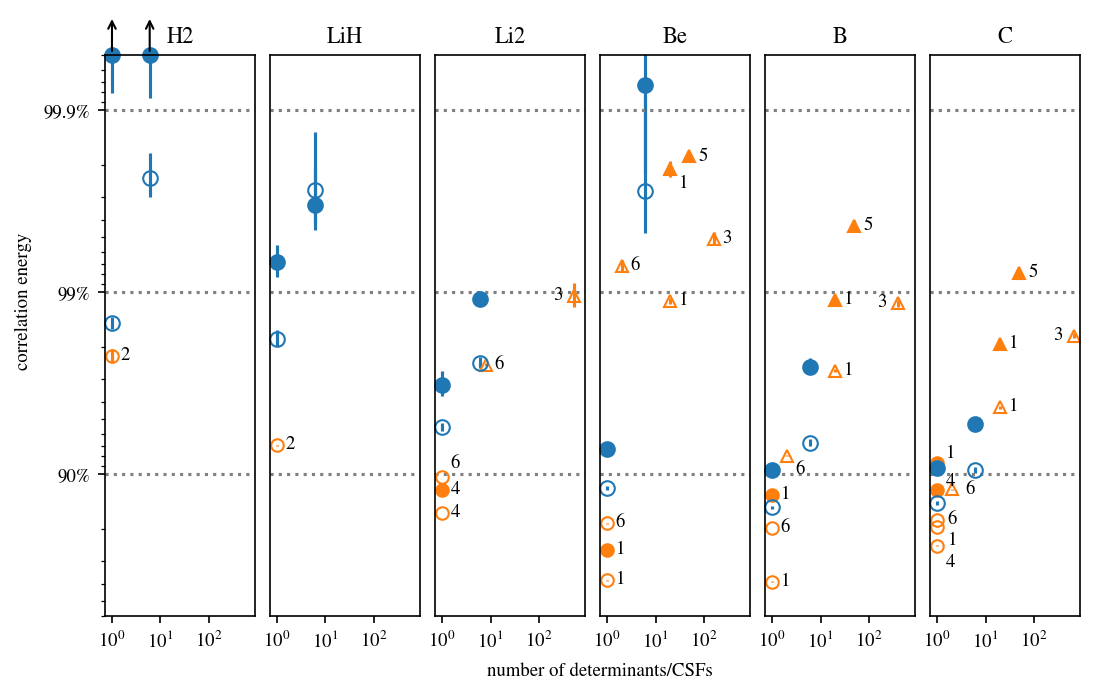

In [80]:
label_reposition = np.ones([6,6,4,2]) # H2 LiH Li2 Be B C / ref / ansatz
label_reposition[[2,2,3,4,4,5,5,5,5,5,5,5],[5,2,0,2,5,5,3,0,5,3,0,2],[0,2,3,2,2,0,0,0,2,1,1,2]]=np.array([[1,0.85],[0.25,1],[1,1.2],[0.25,1],[1,1.2],[1.1,1],[1,1.25],[1.1,1.2],[1.3,1.],[1.,0.9],[1.,0.9],[0.25,1]])
width= 7.18
fig, axs = plt.subplots(1, 6, sharex='all', figsize= (width,width*5/8))
for s,(system,axi) in enumerate(zip(systems,axs)):
    axi.set_title(system)
    for j,ref in enumerate(['Brown', 'Casalengo', 'Morales', 'Rios', 'Seth', 'Toulouse']): 
        dj = get_ref(refs_qmc,ref,system)
        for k,l in product(range(2),range(2)):
            axi.errorbar(dj[k+2*l,2],dj[k+2*l,0],dj[k+2*l,1],fillstyle=['none','full'][k],ls='',marker=['o','^'][l],c=f"C1",ms=6)
        for i,(y,_,x) in enumerate(dj):
            axi.annotate(j+1,(x*1.5,y*1.05)*label_reposition[s,j,i])
    ds = data_paulinet[s]
    for k in range(2):
        axi.errorbar([1,1,6,6][k::2],ds[k::2,0].clip(0.05),ds[k::2,1],label=('Slater Jastrow','Slater Jastrow Backflow')[k],ls='',marker='o',fillstyle=['none','full'][k],ms=7,color=f"C0", clip_on=False)
    for i,p in enumerate(ds[:,0]):
        if p < 0.05:
            axi.annotate("",xy=([1,6][i//2], 0.05), xycoords='data',xytext=([1,6][i//2], 0.03), textcoords='data',arrowprops=dict(arrowstyle="<-"),annotation_clip=False,)
    axi.set_yscale('log')
    axi.set_xscale('log')
    for i in [0.1,1,10]:
        axi.axhline(i,ls=':',color='grey')
    if s==0:
        axi.set_yticks([0.1,1,10])
        axi.set_yticklabels(['99.9%','99%','90%'])
    else:
        axi.set_yticks([])  
        axi.tick_params(axis='y', which='both', length=0)
    axi.set_xticks([1,10,100])
    axi.set_ylim(60,0.05)
fig.tight_layout()
fig.text(0.535, 0.0,'number of determinants/CSFs', ha='center', va='center')
fig.text(0.0, 0.55,  'correlation energy', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(wspace = 0.1, hspace = 0 )